<a href="https://colab.research.google.com/github/HereBeCode/StanceDetectionML-Brockport/blob/main/MultiClass_YT_Comment_Sentiment_Classification_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import string
import re
import nltk
import numpy as np
import pandas as pd
import operator
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from textblob import TextBlob

from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import  word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
filename = "/content/DataAbortionNLPAugBalanced.csv"
df = pd.read_csv(filename, usecols=["commentTextDisplay", "label"], encoding="utf-8")
print(df)

df = df[(df.label == 0) | (df.label == 1) | (df.label == 2)]
df = df.astype({'label': int})
print(df)

                                     commentTextDisplay  label
0     murderers. good for the marchers and the life ...      2
1     bacteria on mars is life, but not a heartbeat ...      2
2     i have a question. how do you abort a full ter...      2
3     i swear pro lifers will care so much about an ...      1
4     ['now i feel sick like the non - nuanced view ...      0
...                                                 ...    ...
6448  i am anti-slavery and anti-forced-incubation. ...      1
6449  imagine if we lived in a world where you could...      1
6450  honestly this was a bit too much of an emotion...      2
6451  this is so sad. i want to know the real reason...      1
6452  when did murdering an unborn child become a ri...      2

[6453 rows x 2 columns]
                                     commentTextDisplay  label
0     murderers. good for the marchers and the life ...      2
1     bacteria on mars is life, but not a heartbeat ...      2
2     i have a question. how d

In [ ]:
#Clean the text
wordnet_lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

def remove_html_and_other(text):
    new_text = re.sub(r'<a href.*\/a>', ' ', text)
    new_text = (new_text.replace('<br /', ' ').
                replace('&#39;', "'").
                replace('<br >', ' ').
                replace('<br>', ' ').
                replace('\u2026', ' ').
                replace('&amp;', '&').
                replace('&quot;', '"').
                replace('1st', 'first ').
                replace('2nd', 'second ').
                replace('3rd', 'third ').
                replace('100%', 'one hundred percent ')
    )
    return new_text

def remove_non_alphabets(text):
    new_text = ""
    for x in range(len(text)):
        if(re.match('[a-zA-z\ ]+', text[x])):
            new_text += text[x]
    return new_text

def tokenize(sentence):
    new_sentence = nltk.word_tokenize(sentence)
    return new_sentence

def remove_stopwords(sentence):
    new_sentence = [word for word in sentence if not word in stop_words]
    return new_sentence

def lemmatize(sentence):
    new_sentence = [wordnet_lemmatizer.lemmatize(word) for word in sentence]
    return new_sentence

def cleanTxt(text):
  text = text.lower()
  text = remove_html_and_other(text)
  text = remove_non_alphabets(text)
  text = tokenize(text)
  text = remove_stopwords(text)
  text = lemmatize(text)
  text = TreebankWordDetokenizer().detokenize(text)

  return text

df['commentTextDisplay']=df['commentTextDisplay'].apply(cleanTxt)

In [ ]:
#Create a function to get the subjectivity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

#Create a function to get the polarity
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

#Create two new columns
df['Subjectivity'] = df['commentTextDisplay'].apply(getSubjectivity)
df['Polarity'] = df['commentTextDisplay'].apply(getPolarity)

df

,commentTextDisplay,label,Subjectivity,Polarity
0,murderer good marcher life child everywhere,2,0.600000,0.700000
1,bacteria mar life heartbeat earth tom macdonald,2,0.000000,0.000000
2,question abort full term baby grab neck choke ...,2,0.316667,0.250000
3,swear pro lifer care much unborn fetus mother ...,1,0.200000,0.200000
4,[feel sick like non nuanced view hail abortion...,0,0.380357,-0.019048
...,...,...,...,...
6448,antislavery antiforcedincubation forced serve ...,1,0.200000,-0.300000
6449,imagine lived world could dictate someone else...,1,1.000000,-0.500000
6450,honestly bit much emotional argument im pro li...,2,0.775000,0.300000
6451,sad want know real reason dont want abortion b...,1,0.384375,0.131250


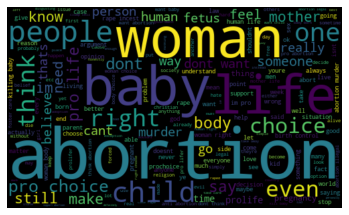

In [ ]:
# Plot Word Cloud
allWords = ' '.join( [comments for comments in df['commentTextDisplay']])
wordCloud = WordCloud(width = 500, height=300, random_state=21, max_font_size=110).generate(allWords)

plt.imshow(wordCloud,interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
df = df.drop(['Subjectivity'], axis=1)
x_data = df.drop(['label'], axis=1)
y_data = df['label'].values

In [ ]:
#Prepare the train/test sets for SVM model
train_X, test_X, train_y, test_y = model_selection.train_test_split(df[["commentTextDisplay",'Polarity']],df["label"], test_size=0.10, random_state=1000)

tfidf_vect = TfidfVectorizer(max_features=2000)
text_train_X = tfidf_vect.fit_transform(train_X['commentTextDisplay']).toarray()
text_test_X = tfidf_vect.transform(test_X['commentTextDisplay']).toarray()
polarity_train_X = train_X['Polarity'].to_numpy()
polarity_train_X = polarity_train_X.reshape(len(polarity_train_X),1)
polarity_test_X = test_X['Polarity'].to_numpy()
polarity_test_X = polarity_test_X.reshape(len(polarity_test_X),1)
final_train_X = np.hstack((text_train_X, polarity_train_X))
final_test_X = np.hstack((text_test_X, polarity_test_X))



In [ ]:
#SVM Model
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(final_train_X, train_y)
predictions_SVM = SVM.predict(final_test_X)
print("SVM Accuracy Score: ", accuracy_score(predictions_SVM, test_y)*100)

SVM Accuracy Score:  87.61609907120743


In [ ]:
actual_labels = []
for x in range(len(test_y)):
  actual_labels.append(test_y.iloc[x])

In [ ]:
print(predictions_SVM)
print(actual_labels)

[0 2 0 1 2 2 0 0 2 2 1 2 1 0 0 0 1 1 2 0 0 2 1 0 1 0 0 1 0 2 0 1 1 2 2 0 0
 2 0 0 0 2 2 2 2 1 2 0 0 0 2 2 2 1 0 0 0 1 0 1 1 2 1 2 2 2 1 2 2 1 1 1 0 1
 1 0 0 2 1 0 2 1 0 1 2 1 0 1 2 2 2 1 2 1 1 0 2 2 0 0 0 1 0 2 1 0 0 2 2 1 2
 0 2 2 0 0 1 1 2 0 0 2 2 2 2 0 2 0 0 2 1 0 1 2 0 2 1 2 2 1 0 0 1 1 1 2 0 2
 2 2 2 2 1 2 1 0 1 1 0 0 1 2 0 1 1 2 0 1 1 2 1 0 0 2 0 0 2 2 2 0 1 1 1 1 0
 0 0 1 0 2 0 0 2 2 0 1 2 1 0 2 0 0 0 0 2 2 1 0 1 2 0 0 2 2 2 0 2 2 1 2 0 2
 0 0 0 0 1 0 2 0 0 0 2 0 1 2 0 0 1 2 0 1 2 2 1 2 2 0 0 2 1 2 1 2 1 2 0 0 1
 1 0 1 1 1 1 2 0 0 2 0 0 1 0 1 2 2 0 1 0 2 2 2 0 2 0 1 2 0 2 2 2 0 1 1 0 2
 0 1 0 0 0 2 0 1 0 0 0 0 1 1 0 1 2 1 2 1 0 2 0 1 1 2 0 0 2 1 2 0 0 1 0 1 1
 2 2 0 2 1 1 1 0 1 0 1 1 1 1 2 0 2 0 0 2 1 0 2 0 0 0 1 0 1 0 0 0 1 2 1 1 2
 2 0 1 0 2 2 1 0 1 1 0 2 2 1 1 0 0 2 0 2 2 2 0 1 0 2 0 1 1 0 2 0 1 2 0 0 2
 2 0 2 0 0 0 2 0 1 1 1 2 1 1 1 2 2 2 2 1 1 0 1 0 2 1 0 2 2 0 1 2 1 1 0 2 1
 2 2 2 0 2 0 2 2 1 2 0 1 2 2 1 1 2 2 0 0 0 1 1 2 2 1 2 1 2 1 1 2 0 2 1 2 2
 0 2 0 2 0 0 2 1 0 0 0 2 

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
accuracy = accuracy_score(actual_labels, predictions_SVM)
precision = precision_score(actual_labels, predictions_SVM, average = "macro")
recall = recall_score(actual_labels, predictions_SVM, average = "macro")
f1_score = f1_score(actual_labels, predictions_SVM, average = "macro")

print("Accurary: " + str(accuracy))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F1 Score: " + str(f1_score))

Accurary: 0.8761609907120743
Precision: 0.8753419549879727
Recall: 0.8772123084536193
F1 Score: 0.8754610526896753
